In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('/Users/yangzhihan/Desktop/projects/bishop1995_notes/modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

## Problem 1: observations are non-markovian

In [2]:
times = np.arange(0, 20, 0.01)
states = np.sin(times) * times

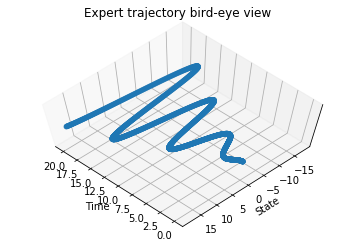

In [3]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(times, states)
ax.view_init(70, 135)
ax.set_zticks([])
ax.set_title('Expert trajectory bird-eye view', y=1.08)
ax.set_xlabel('Time')
ax.set_ylabel('State')
plt.show()

In [4]:
x_train, y_train = states[:-1].reshape(-1, 1), states[1:].reshape(-1, 1)
x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

In [5]:
class Regressor(nn.Module):
    
    def __init__(self, num_hyperplanes):
        super().__init__()
        
        self.main = nn.Sequential(
            
            nn.Linear(1, num_hyperplanes),
            nn.BatchNorm1d(num_hyperplanes),
            nn.ReLU(),
            
            nn.Linear(num_hyperplanes, 1),
            nn.BatchNorm1d(1),
            nn.ReLU(),
        
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1)

In [6]:
def get_model(num_hyperplanes):
    nn = Regressor(num_hyperplanes)
    return nn, optim.Adam(nn.parameters(), lr=1e-4)

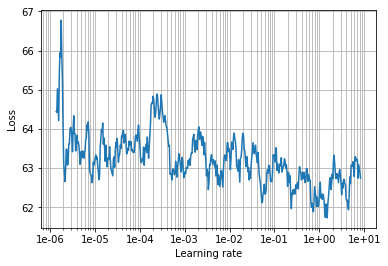

In [7]:
model, opt = get_model(100)
def loss(ypreds, yb):
    return torch.mean((yb - ypreds) ** 2)
learn = Learner(train_dl, train_dl, model, loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

trainer.find_lr(beta=0.98, final_value=10, num_itr=500)